## Double Q Learning

`Q-Learing`是`ModelFree`的自举(`bootstrapped`)的`off-policy`算法。

`Q-Learning`中有一个问题被称为`maximization bias`，说的是:

1. 对于给定的状态`state`，有多个候选动作`action`，其中真实的$q(s, a)=0$。但是估计的$Q(s, a)$是不确定的，并且会存在一个正向的偏差`positive bias`。
2. 最大化真实的`q`值的话，是`0`。但是，最大化$Q(s, a)$会是一个正数，因此会产生一个`positive bias`。

解决这个问题的方法就是用两个独立的$Q$函数，一个用来确定最大的动作，一个用来确定最大的q值。并且将这二者交互迭代更新。

## 算法


1. 初始化学习率$\alpha$和贪婪概率$\epsilon$。
2. 初始化$Q1(s, a)$和$Q2(s, a)$
3. 循环episodes
    - 初始化状态$S$
    - 循环每个episode
        - 基于贪婪策略从$Q_{1} + Q_{2}$中选择状态$S$对应的动作$A$。
        - 采取动作$A$, 接收环境的即时奖励$R$和下一个状态$S^{\prime}$。
        - 基于0.5的概率
            - $Q_{1} = Q_{1} + \alpha * (R + \gamma * (Q_{2}(S^{\prime}, argmax Q_{1}(S^{\prime}, a)) - Q_{1})$
            - $Q_{2} = Q_{2} + \alpha * (R + \gamma * (Q_{1}(S^{\prime}, argmax Q_{2}(S^{\prime}, a)) - Q_{1})$
        - 更新状态$S = S^{\prime}$。

## 代码

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym

定义一个函数，用来获取当前状态下，所有的动作价值函数$Q$, 然后来获取对应的动作。

但是与Sarsa不同，这里需要传入两个Q，Q1和Q2。选择最大的动作时，是选择二者之和最大的那个动作。

In [2]:
def maxAction(Q1, Q2, state):    
    values = np.array([Q1[state,a] + Q2[state, a] for a in range(2)])
    action = np.argmax(values)
    return action

对应的将观测值进行离散化，将其离散化为10个

In [3]:
# discretize the space
cartPosSpace = np.linspace(-2.4, 2.4, 10)
cartVelSpace = np.linspace(-4, 4, 10)
poleThetaSpace = np.linspace(-0.20943951, 0.20943951, 10)
poleThetaVelSpace = np.linspace(-4, 4, 10)

之后我们还需要一个能够将观测转化成离散量的函数。

In [4]:
def getState(observation):
    cartX, cartXdot, cartTheta, cartThetadot = observation
    
    cartX = int(np.digitize(cartX, cartPosSpace))  # 小车的位置X。
    cartXdot = int(np.digitize(cartXdot, cartVelSpace))  # 小车速度
    cartTheta = int(np.digitize(cartTheta, poleThetaSpace))  # 摆杆角度
    cartThetadot = int(np.digitize(cartThetadot, poleThetaVelSpace))  # 摆杆速度
    
    return (cartX, cartXdot, cartTheta, cartThetadot)

再定义一个画奖励曲线的函数，取最后一百个episode的奖励平均作为画图点:

In [5]:
def plotRunningAverage(totalRewards):
    N = len(totalRewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(totalRewards[max(0, t-100) : (t+1)])
    plt.plot(running_avg)
    plt.title("Running Average")
    plt.show()

starting game 0
starting game 5000
starting game 10000
starting game 15000
starting game 20000
starting game 25000
starting game 30000
starting game 35000
starting game 40000
starting game 45000
starting game 50000
starting game 55000
starting game 60000
starting game 65000
starting game 70000
starting game 75000
starting game 80000
starting game 85000
starting game 90000
starting game 95000


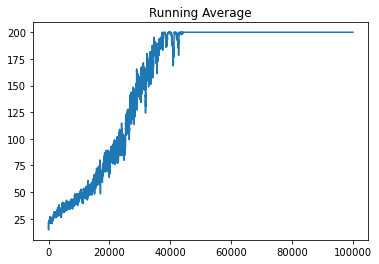

In [6]:
if __name__ == "__main__":
    env = gym.make('CartPole-v0')
    # 模型超参数
    ALPHA = 0.1
    GAMMA = 1.0  # 到立摆的状态转移是确定的
    EPS = 0.9
    
    # 构造状态空间, 四层for循环穷举所有的状态空间。
    states = []
    for i in range(len(cartPosSpace)+1):
        for j in range(len(cartVelSpace)+1):
            for k in range(len(poleThetaSpace)+1):
                for l in range(len(poleThetaVelSpace)+1):
                    states.append((i, j, k, l))
    
    # 初始化所有的Q为0
    Q1, Q2 = {}, {}
    for s in states:
        for a in range(2):  # 动作空间只有两个维度，向左和向右。
            Q1[s, a] = 0
            Q2[s, a] = 0
    
    # 因为要处理Q估计的偏差，所以收敛速度会更慢一点。
    numGames = 100000
    totalRewards = np.zeros(numGames)
    for i in range(numGames):
        if i % 5000 == 0:
            print("starting game {}".format(i))
        # 获取观测：小车的位置X，小车速度，摆杆角度，摆杆速度
        observation = env.reset()
        
        done = False
        epRewards = 0

        while not done:
            s = getState(observation)
            rand = np.random.random()
            a = maxAction(Q1, Q2, s) if rand < (1-EPS) else env.action_space.sample()
        
            observation_, reward, done, info = env.step(a)
            epRewards += reward
            
            s_ = getState(observation_)
            rand = np.random.random()
            if rand <= 0.5:
                a_ = maxAction(Q1, Q1, s_)
                Q1[s, a] = Q1[s, a] + ALPHA*(reward + GAMMA*Q2[s_, a_] - Q1[s, a])
            else:
                a_ = maxAction(Q2, Q2, s_)
                Q2[s, a] = Q2[s, a] + ALPHA*(reward + GAMMA*Q1[s_, a_] - Q2[s, a])
                
#             a_ = maxAction(Q, s_) if rand < (1-EPS) else env.action_space.sample()
            
            
#             Q[s,a] = Q[s,a] + ALPHA*(reward + GAMMA*Q[s_, a_] - Q[s, a])
            observation = observation_

        EPS -= 2/(numGames) if EPS > 0 else 0
        totalRewards[i] = epRewards
        
    
    plotRunningAverage(totalRewards)